In [34]:
import pandas as pd
import numpy as np

# TODO: disentangle EE and ES!!!!
#  convert this matlab code to python list format
filenames = ['interleaved_incomplete',
             'block_incomplete',
             'block_complete',
             'block_complete_simple',
             'block_complete_mixed',
             'block_complete_mixed_2s',
             'block_complete_mixed_2s_amb_heuristic',
             'block_complete_mixed_2s_amb',
             'incentivize']

filenames2 = ['exp_1_interleaved_incomplete',
              'exp_2_block_incomplete',
              'exp_3_block_complete',
              'exp_4_block_complete_simple',
              'exp_5_block_complete_mixed',
              'exp_6_block_complete_mixed_2s',
              'exp_7_block_complete_mixed_2s_deactivate',
              'exp_8_block_complete_mixed_2s_amb',
              'exp_9_incentives']

# for f in filenames:
# print(f)
# df1 = pd.read_csv('data/behavior/csv/' + f + '.csv')

# ----------------------------------------------
#  This code is used to add prolific id to the data
# if f == 'block_complete_mixed':
#     df2 = pd.read_csv('data/behavior/with_prolific_id/' + f + '.csv')
#     df2.columns=["F"+str(i) for i in range(1, df2.shape[1]+1)]
#     break
#  rename columns
# for sub_id in df1['sub'].unique():
#     if np.isnan(sub_id):
#         continue


#     df1.loc[df1['sub'] == sub_id, 'prolific_id'] = df2['F3'][df2['F2'] == sub_id].values[0]
# ----------------------------------------------

for f, f2 in zip(filenames, filenames2):
    df = pd.read_csv(f'data/behavior/csv/{f}.csv')

    df.drop(['Unnamed: 0',
             'prolific_id',
             'cont1', 'cont2',
             'dbtime', '10',
             '26', '15', '16',
             'dist', 'plot'], axis=1, inplace=True)

    df.rename(columns={'17': 'chose_right', 'elic': 'phase',
              'sub': 'sub_id', '25': 'reversed'}, inplace=True)
    df['chose_right'] = (df.chose_right > 0).astype(int)

    count = 0
    for sub in df.sub_id.unique():

        if np.isnan(sub):
            # drop nan sub
            df.drop(df[df.sub_id == sub].index, inplace=True)

        LE = (df.phase == -1) & (df.cond != -1) & (df.sub_id == sub)
        # count += sum(LE) == 120
        df.loc[LE, 'phase'] = 'LE'
        df.loc[LE, 'op1'] = 'E'
        df.loc[LE, 'op2'] = 'E'

        ES = (df.phase == 0) & (df.sub_id == sub) & (df.op2.isin(
            [0, -1])) & (df.op1.isin([1, -1, 0])) & (df.sub_id == sub)
        # assert len(LE[ES]) == 0
        # assert all(LE[ES] == False)
        # print(sum(ES))
        df.loc[ES, 'phase'] = 'ES'

        SP = (df.phase == 2) & (df.sub_id == sub)
        df.loc[SP, 'phase'] = 'SP'
        df.loc[SP & (df.catch == 0), 'op1'] = 'E'
        df.loc[SP & (df.catch == 1), 'op1'] = 'S'
        df.loc[SP, 'op2'] = np.NaN
        df.loc[SP, 'p2'] = np.NaN
        df.loc[SP, 'ev2'] = np.NaN
        df.loc[SP, 'cond'] = np.NaN

        if f in ('block_complete_mixed',
                 'block_complete_mixed_2s',
                 'block_complete_mixed_2s_amb_heuristic',
                 'block_complete_mixed_2s_amb',
                 'incentivize'):
            EE = (df.phase == 0) & (df.op2 == 1) & (df.sub_id == sub)
            assert all((EE[ES] == False))
            df.loc[EE, 'phase'] = 'EE'
            df.loc[EE, 'op1'] = 'E'
            df.loc[EE, 'op2'] = 'E'
            df.loc[EE, 'cond'] = np.NaN
            # print(sum(EE)) 

        if 'amb' in f:
            EA = (df.phase == 0) & (df.op2 == 2) & (
                df.op1 == 1) & (df.sub_id == sub)
            df.loc[EA, 'phase'] = 'EA'

            df.loc[EA, 'op1'] = 'E'
            df.loc[EA, 'op2'] = 'A'
            df.loc[EA, 'cond'] = np.NaN

            SA = (df.phase == 0) & (df.op2 == 2) & (
                df.op1 == 0) & (df.sub_id == sub)

            df.loc[SA, 'phase'] = 'SA'
            df.loc[SA, 'op1'] = 'S'
            df.loc[SA, 'op2'] = 'A'
            df.loc[SA, 'cond'] = np.NaN

        df.loc[ES, 'op1'] = 'E'
        df.loc[ES, 'op2'] = 'S'
        df.loc[ES, 'cond'] = np.NaN

    df.loc[df.catch == -1, 'catch'] = 0
    df.loc[df.op2 == -1, 'op2'] = np.NaN
    df.loc[df.p2 == -1, 'op2'] = np.NaN
    df.rename(columns={'catch': 'catch_trial'}, inplace=True)
    df.to_csv(f'data/behavior/reformat/{f2}.csv', index_label='index')


<Axes: xlabel='cond', ylabel='corr'>

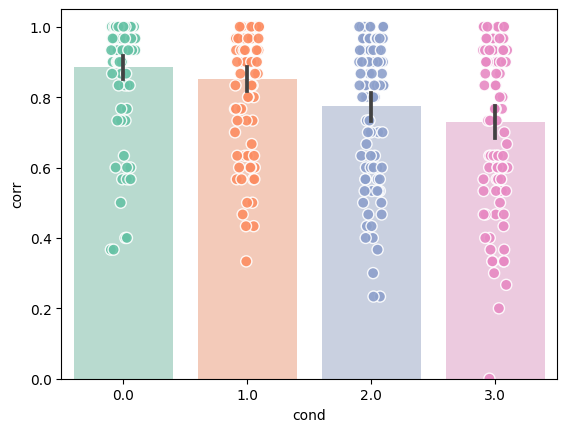

In [54]:
import seaborn as sns
df = pd.read_csv('./data/behavior/reformat/block_complete.csv')
where = df.groupby('sub_id').phase.count().isin([288, 258])
ids = where.index[where.values]
df = df[df.sub_id.isin(ids)]
df = df[df.sess == 0]
df2 = df.groupby(['sub_id', 'phase', 'cond'], as_index=False)['corr'].mean()

df2 = df2[df2.phase == 'LE']
sns.set_palette('Set2')
sns.barplot(data=df2, x='cond', y='corr', alpha=.5, zorder=-1)
sns.stripplot(data=df2, x='cond', y='corr', palette='Set2',
              edgecolor='white', linewidth=1., size=8, zorder=0, alpha=.9)


In [38]:
# check length
df = pd.read_csv('./data/behavior/reformat/exp_6_block_complete_mixed_2s.csv')
where = df.groupby('sub_id').phase.count().isin([648, 658])
ids = where.index[where.values]
df = df[df.sub_id.isin(ids)]
df = df[df.sess == 1]
print('Nsub=', len(df.sub_id.unique()))
print('phase=', df.phase.unique())
df.groupby(['sub_id', 'catch_trial'], as_index=False).phase.value_counts()

Nsub= 82
phase= ['LE' 'ES' 'EE' 'SP']


,sub_id,catch_trial,phase,count
0,1.072266e+08,0.0,LE,120
1,1.072266e+08,0.0,ES,88
2,1.072266e+08,0.0,EE,56
3,1.072266e+08,0.0,SP,8
4,1.072266e+08,1.0,ES,8
...,...,...,...,...
487,9.977206e+09,0.0,ES,88
488,9.977206e+09,0.0,EE,56
489,9.977206e+09,0.0,SP,8
490,9.977206e+09,1.0,ES,8
